# Source: https://scikit-learn.org/stable/auto_examples/decomposition/plot_image_denoising.html

In [1]:
import numpy as np
import sklearn
import scipy.linalg as LA
import matplotlib.pyplot as plt

## Import test image from scipy

In [2]:
from scipy.datasets import face

raccoon_face = face(gray=True).astype(np.float64)

# normalize
raccoon_face /= 255.0

# downsample for speed
raccoon_face = raccoon_face[::4, ::4] + raccoon_face[2::4, ::4] + raccoon_face[::4, 2::4] + raccoon_face[2::4, 2::4]
raccoon_face /= 4
height, width = raccoon_face.shape

# Distort the right half of the image
print('Distorting image')
distorted = raccoon_face.copy()
distorted[:, width // 2:] += .075 * np.random.randn(height, width // 2)

Distorting image


## Display distorted image

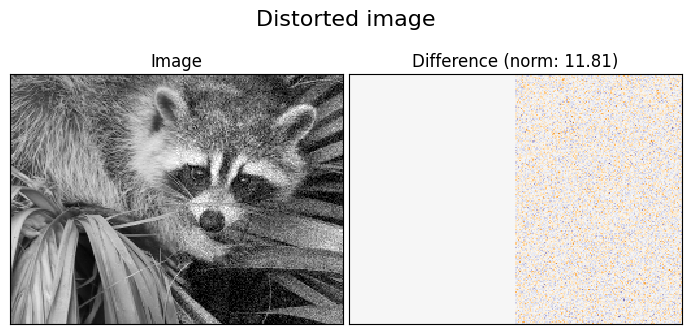

In [3]:
def show_with_diff(image, reference, title):
    plt.figure(figsize=(7, 3.3))
    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    
    plt.subplot(1, 2, 2)
    difference = image - reference

    plt.title('Difference (norm: %.2f)' % np.sqrt(np.sum(difference**2)))
    plt.imshow(
        difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr, interpolation='nearest'
    )
    plt.xticks(())
    plt.yticks(())
    plt.suptitle(title, size=16)
    plt.subplots_adjust(.02, .02, .98, .79, .02, .2)

show_with_diff(distorted, raccoon_face, 'Distorted image')

## Extract reference patches

In [4]:
from time import time
from sklearn.feature_extraction.image import extract_patches_2d

# Extract patches from left half of the image
print('Extracting reference patches')
t0 = time()
patch_size = (7, 7)
data = extract_patches_2d(distorted[:, :width // 2], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print(f'{data.shape[0]} patches extracted in %.2fs.' % (time() - t0))

Extracting reference patches
22692 patches extracted in 0.01s.


# Inital KSVD implementation

In [5]:
from sklearn.decomposition import SparseCoder

def kSVD(Y, T_0, k, num_iter, track_loss = True, verbose:int = 0):
    loss = np.empty(num_iter)

    # Initialize dictionary
    t0 = time()
    D = np.random.randn(k, Y.shape[1])
    D = np.diag(1 / LA.norm(D, ord=2, axis=1)) @ D

    if verbose > 0:
        print(f'Initialization Time: {time() - t0}')
    
    for iter in range(num_iter):
        t0 = 0
        if verbose > 0:
            print(f'Iteration {iter}:')
            t0 = time()
        
        # Sparse Coding Step
        # if debug:
        #     print(f'Iteration {iter}, Sparse Coding Step...')
        
        X = SparseCoder(dictionary = D, transform_n_nonzero_coefs = T_0).transform(Y)
        if verbose > 0:
            print(f'\tCoding Time: {time() - t0}')
        
        # Dictionary Update Step
        # if debug:
        #     print(f'Iteration {iter}, Dictionary Update Step...')
        t0 = time()
        unused_atom = False
        for i in range(k):
            x_i = X[:, i]
            filter = (x_i != 0)
            x_i_R = x_i[filter]
            if x_i_R.shape[0] == 0:
                # print('Warning: Dictionary atom unused? Skipping update...')
                unused_atom=True
                continue
            
            E_k_R = Y[filter]
            for j in range(k):
                if j != i:
                    # print(X[filter, j][:, np.newaxis].shape)
                    # print(D[j][np.newaxis, :].shape)
                    E_k_R -= X[filter, j][:, np.newaxis] @ D[j][np.newaxis, :]

            # print(E_k_R.shape)
            U, S, Vh = LA.svd(E_k_R)

            X[filter, i] = U[:, 0] * S[0]
            D[i] = Vh[0]

        if verbose > 0:
            print(f'\tUpdate Time: {time() - t0}')
            print(f'\tUnused Atom: {unused_atom}')
        
        loss[iter] = LA.norm(Y - X @ D, ord='fro')

    return D, loss

In [6]:
def plot_log_loss(loss, linestyle='-', alpha = 1):
    plt.semilogy(loss, linestyle=linestyle, alpha = alpha)
    plt.title('Log-Loss vs iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Log-Loss')
    # plt.show()

Initialization Time: 0.001032114028930664
Iteration 0:
	Coding Time: 0.030965089797973633
	Update Time: 0.19099998474121094
	Unused Atom: True
Iteration 1:
	Coding Time: 0.025355100631713867
	Update Time: 0.1660001277923584
	Unused Atom: True
Iteration 2:
	Coding Time: 0.02631211280822754
	Update Time: 0.18801546096801758
	Unused Atom: True
Iteration 3:
	Coding Time: 0.02798604965209961
	Update Time: 0.18790793418884277
	Unused Atom: True
Iteration 4:
	Coding Time: 0.030896663665771484
	Update Time: 0.18712949752807617
	Unused Atom: True
Iteration 5:
	Coding Time: 0.030675649642944336
	Update Time: 0.18503212928771973
	Unused Atom: True
Iteration 6:
	Coding Time: 0.03128170967102051
	Update Time: 0.1838545799255371
	Unused Atom: True
Iteration 7:
	Coding Time: 0.026599645614624023
	Update Time: 0.18897223472595215
	Unused Atom: True
Iteration 8:
	Coding Time: 0.02579331398010254
	Update Time: 0.18103432655334473
	Unused Atom: True
Iteration 9:
	Coding Time: 0.03003096580505371
	Update 

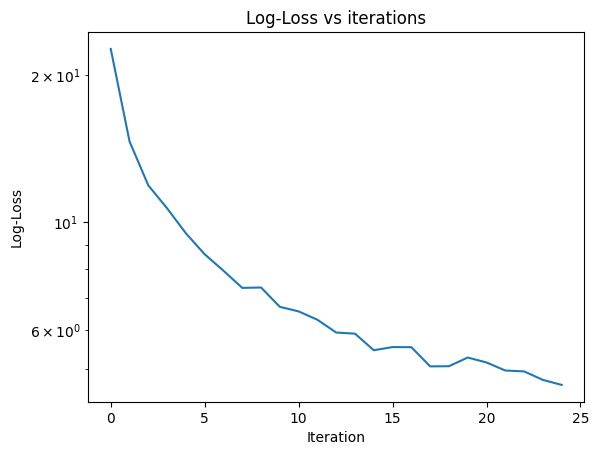

In [7]:
D, loss = kSVD(data[:200], 5, 200, 25, verbose=1)
plot_log_loss(loss)

Avg Time: 11.16113018989563


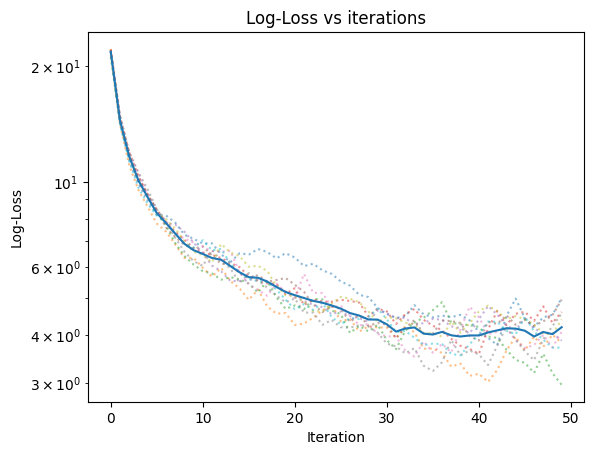

In [8]:
avg_loss = 0
runs = 10
avg_time = 0
for i in range(runs):
    t0 = time()
    D, loss = kSVD(data[:200], 5, 200, 50, verbose=0)
    avg_time += ((time() - t0) - avg_time) / (i+1)
    # plt.plot(np.log10(loss))
    plot_log_loss(loss, linestyle=':', alpha = .5)
    avg_loss += (loss - avg_loss) / (i+1)

print(f'Avg Time: {avg_time}')
plot_log_loss(avg_loss)
plt.show()

## Learn the dictionary from reference patches

### Hyperparams have been set to try to match those in the sklearn example and the results obtained for a more fair comparison!

Learning the dictionary
Initialization Time: 0.0
Iteration 0:
	Coding Time: 0.5070016384124756
	Update Time: 8.585862159729004
	Unused Atom: False
Iteration 1:
	Coding Time: 0.5040256977081299
	Update Time: 4.7413330078125
	Unused Atom: False
Total Time: 14.36.


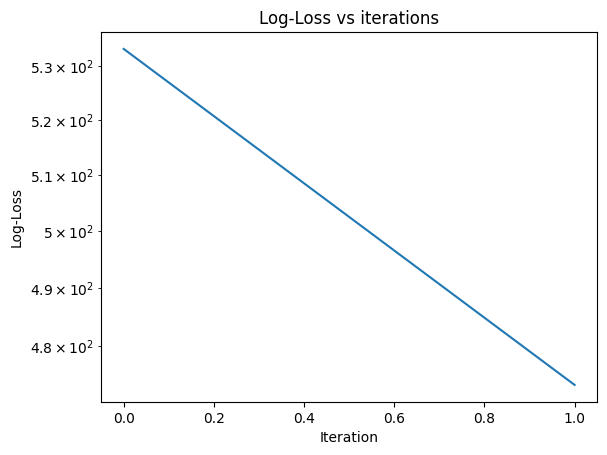

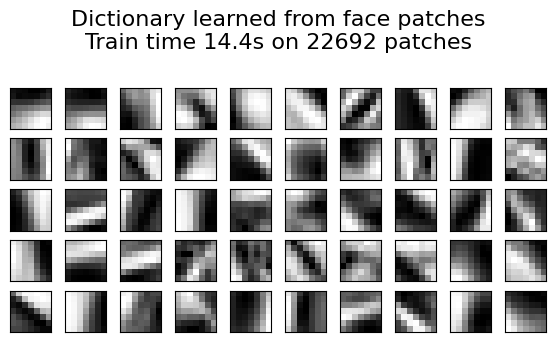

In [9]:
print('Learning the dictionary')
t0 = time()
num_iter = 2
Y = data
D, loss = kSVD(Y = Y, 
               T_0 = 1, 
               k = 50, 
               num_iter = num_iter, 
               verbose=1)
dt = time() - t0
print(f'Total Time: {dt:.2f}.')
plot_log_loss(loss)

plt.figure(figsize=(6.5, 6))
for i, comp in enumerate(D[:100]):
    plt.subplot(10, 10, i+1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle(
    'Dictionary learned from face patches\n'
    + 'Train time %.1fs on %d patches' % (dt, len(Y)),
    fontsize=16,
)
plt.subplots_adjust(.08, .02, .92, .85, .08, .23)

## Extract noisy patches and reconstruct them using the dictionary

Extracting noisy patches...
done in 0.01s.
OMP
1 atom...
done in 0.59s.
OMP
2 atoms...
done in 1.37s.
Lars
4 atoms...
done in 10.88s.
Thresholding
 alpha = 0.1...
done in 0.12s.


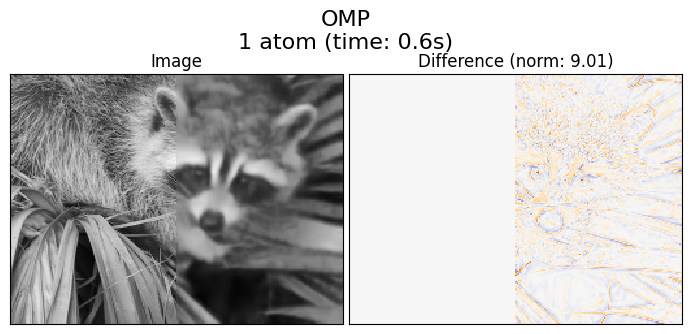

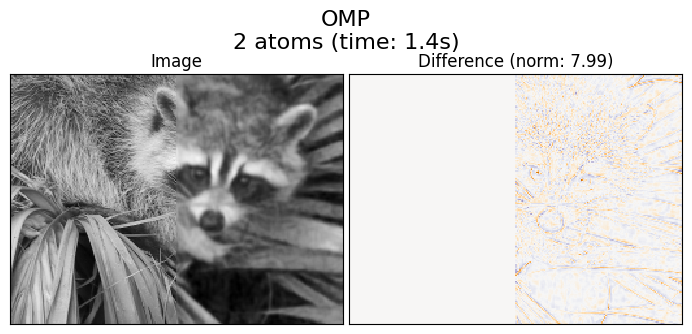

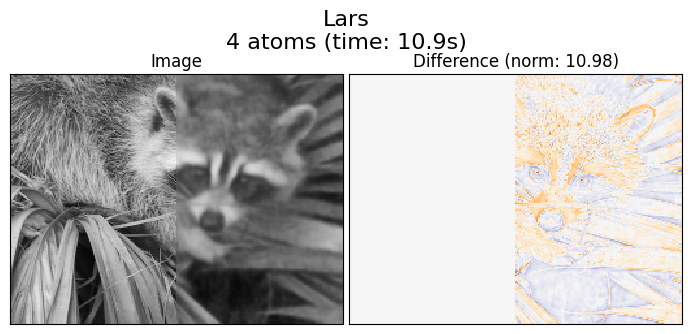

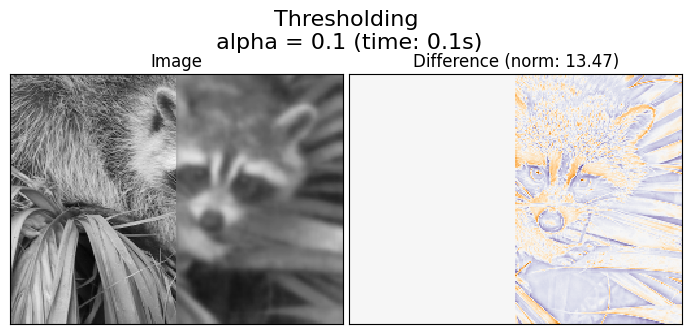

In [10]:
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

print('Extracting noisy patches...')
t0 = time()
data = extract_patches_2d(distorted[:, width // 2 :], patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept
print('done in %.2fs.' % (time() - t0))

transform_algorithms = [
('OMP\n1 atom', 'omp', {'transform_n_nonzero_coefs': 1}),
('OMP\n2 atoms', 'omp', {'transform_n_nonzero_coefs': 2}),
('Lars\n4 atoms', 'lars', {'transform_n_nonzero_coefs': 4}),
('Thresholding\n alpha = 0.1', 'threshold', {'transform_alpha': 0.1}),
]

reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + '...')
    reconstructions[title] = raccoon_face.copy()
    t0 = time()
    coder = SparseCoder(transform_algorithm=transform_algorithm,
                        dictionary = D,
                        **kwargs)
    code = coder.transform(data)
    patches = code @ D

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    if transform_algorithm == 'threshold':
        patches -= patches.min()
        patches /= patches.max()
    reconstructions[title][:, width // 2 :] = reconstruct_from_patches_2d(
        patches, (height, width // 2)
    )
    dt = time() - t0
    print('done in %.2fs.' % dt)
    show_with_diff(reconstructions[title], 
                   raccoon_face, 
                   title + ' (time: %.1fs)' % dt
                  )

plt.show()